In [67]:
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime

In [68]:
data = pd.read_excel('./Internship/data.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7274 entries, 0 to 7273
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   GÜN         7274 non-null   int64  
 1   AY          7274 non-null   object 
 2   YIL         7274 non-null   int64  
 3   Yağış       7274 non-null   float64
 4   Buharlaşma  7274 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 255.8+ KB


## Veri Temizleme/Düzenleme 
Yukarıda görüldüğü üzere verimizde gün, ay, yıl ayrı ayrı yazılmıştır. Bizim yapacağımız işlerde verimizin (datetime) veri tipinde olup, dataFrame objemizin index kısmına koyulması gerekmektedir. Şuanki aşamada datamızdaki verileri düzenleyip bunu doğru bir şekilde index olarak atamaya çalışacağız.
### Yapacağımız işlemler
- Tüm verileri düzenli bir şekilde gezerek sütunları doğru şekilde birleştireceğiz.
- Birleştirme işleminde bir datetime objesi yaratacağız ve bir listeye ekleyeceğiz.
- Ardından ekleme yaptığımız listeyi dataFrame objemize yeni bir sütun olarak ekleyeceğiz.
- Eski sütunları sildikten sonra, objemize yeni eklediğimiz sütunu index olarak atayacağız.

In [69]:
def cleaned_data(data):
    data_copy = data.copy()
    unique_months = data_copy['AY'].unique()
    months = {unique_months[i-1]: i for i in range(1, 13) }

    # Exceptional data.
    months['EKIM'] = 9
    months['NISAN'] = 3
    months['HAZIRAN'] = 5

    date = []
    for index, row in data_copy.iterrows():
        date.append(str(row['YIL'])+'-'+str(months[row['AY']])+ '-'+str(row['GÜN']))

    data_copy['timeseries'] = date
    data_copy['timeseries'] = pd.to_datetime(data_copy['timeseries'], errors = 'coerce')

    data_copy.drop(['GÜN', 'AY', 'YIL'], axis=1, inplace=True)
    data_copy.rename(columns={'Yağış': 'precipitation', 'Buharlaşma': 'vaporization'}, inplace= True)

    # Also remove broken datetime values.
    # Remove NaN values
    data_copy.drop(data_copy[data_copy.timeseries != data_copy.timeseries].index, axis=0, inplace=True)

    data_copy = data_copy.set_index('timeseries')
    return data_copy

# cleaned_data(data)

In [70]:
df = cleaned_data(data)
# Let's see sample 7 data from dataset
df.sample(7)

precipitation  vaporization
timeseries                             
2006-01-26           13.0           0.0
2019-06-12           16.3           1.3
2010-06-04            0.0           4.8
2001-04-12            0.0           3.4
2012-12-14            0.0           0.0
2008-03-24            0.0           2.9
2007-10-07            1.2           0.5

Yukarıda görüldüğü üzere verinin yeni formatı güncellenmiştir. `data` adlı değişkenimizdeki eski verimizde herhangi bir değişiklik yapılmamıştır. `df` adlı yeni değişkenimiz düzenlenmiş olup ileride kullanacağımız değişkendir. Şimdi birkaç metot kullanarak data hakkında yüzeysel ve daha sonrada derine inmemiz gereken bilgiler elde edeceğiz.
* `pandas` kütüphanesinin bize sağlamış olduğu `info()`, `describe()` metotları ile veriye yüzeysel olarak bakacağız.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7139 entries, 2000-01-01 to 2019-11-30
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   precipitation  7139 non-null   float64
 1   vaporization   7139 non-null   float64
dtypes: float64(2)
memory usage: 167.3 KB


In [72]:
df.describe()

precipitation  vaporization
count    7139.000000   7139.000000
mean        2.083989      2.036210
std         6.266561      2.038436
min         0.000000      0.000000
25%         0.000000      0.000000
50%         0.000000      1.600000
75%         0.600000      3.800000
max        99.400000     15.600000

## Verileri ayırıp, zamana karşı test etmek
Bu aşamada verileri yağış ve buharlaşma verileri olarak ikiye ayıracağım. İkiye ayırdığım verileri ayrı ayrı zamana göre inceleyip modelleri ayrı ayrı eğiteceğim.

In [73]:
df_pr = df.drop('vaporization', axis=1)
df_vp = df.drop('precipitation', axis=1)

Öncelikle yağış verisi ile işlemleri gerçekleştireceğim yani şu andan itibaren başka bir değişikliğe kadar __yağış__ verileri ile işlemler yapacağız. Kullanacağımız dataset ise `df_pr` olacaktır.
### İlk olarak yağış verilerini basitçe görselleştireceğim. Burada verimizin zaman ile ne tarz değişiklikler gösterdiğini görmüş olacağız

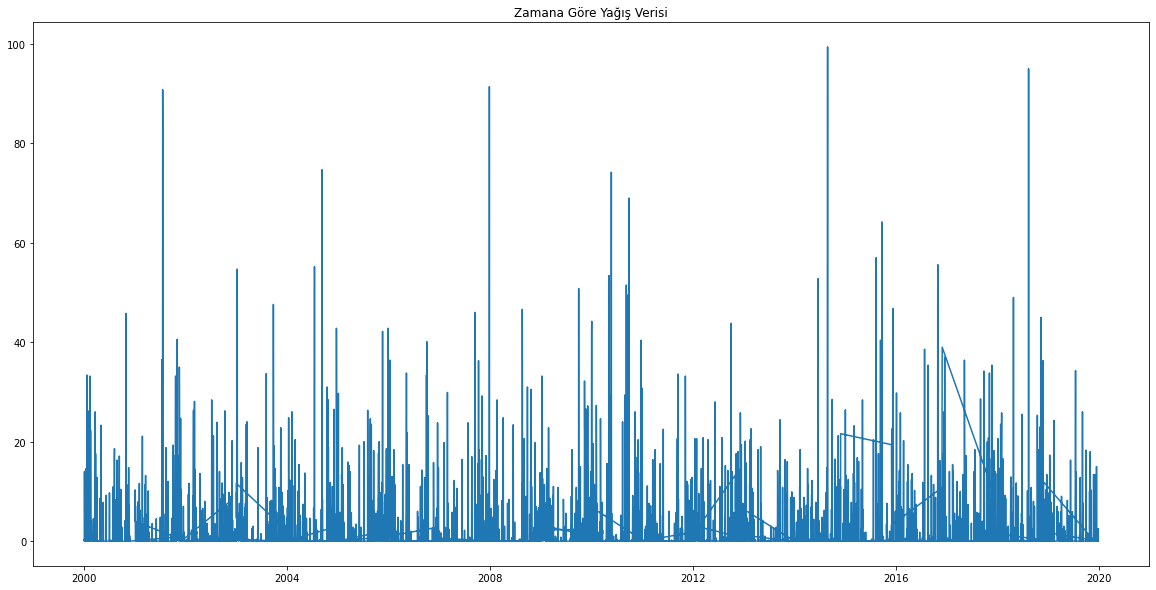

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Zamana Göre Yağış Verisi')
plt.plot(df_pr)
plt.show()

### Yukarıda yağış verisinin zamana göre nasıl değiştiğini görebiliyoruz.
Bizim yağış verisi üzerinden tahmin yapabilmemiz için, verilerin __stationary__ olup olmadığını anlamamız gerekmektedir. Eğer veri __stationary__ değilse veriyi gelecek tahmini yapabilmek adına o konuma getirmeliyiz. <br>
Bir verinin __stationary__ olup olmadığını belirlemek için 2 tane ana yol var.
* Rolling Statistics (Yuvarlama İstatistiği)
* Augmented Dickey-Fuller Test (Arttırılmış Dickey-Fuller Testi)

### Öncelikle _Rolling Statistics_ modelini deneyeceğiz. `rolling_mean()` ve `rolling_std()` değerlerini bulacağız ve normal değerlerimiz ile beraber bu değerleri görselliştirerek verimizin durumunu anlamaya çalışacağız. 
Yuvarlanmış değerleri bulurken `window` parametresine 360 değerini vereceğiz. Bu 360 günlük periyotlar anlamına geliyor diyebiliriz. Bunu yapmamızın sebebi ülkemizde 1 yıl periyotları ile mevsim değişiklikleri yaşanır. Her mevsimde farklı oranlarda yağış gözlemleriz. Bu durumu göz önünde bulundurarak bu değeri 360 olarak almamız gerektiğine karar verdim.

In [78]:
class StationarityTest:

    def dickey_fuller_test(self, timeseries, cutoff=0.01):
        print('Results of Dickey-Fuller Test:')
        dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
        if pvalue < cutoff:
            print('p-value = %.4f. The series is likely stationary.' % pvalue)
        else:
            print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

        print(dfoutput)

    def rolling_statistics_test(self, timeseries, window=360):
        rolling_mean = timeseries.rolling(window).mean()
        rolling_std = timeseries.rolling(window).std()
        
        # rolling statistics plot
        plt.figure(figsize=(13, 8))
        plt.plot(timeseries, color='blue', label='Original')
        plt.plot(rolling_mean, color='red', label='Rolling Mean')
        plt.plot(rolling_std, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
        

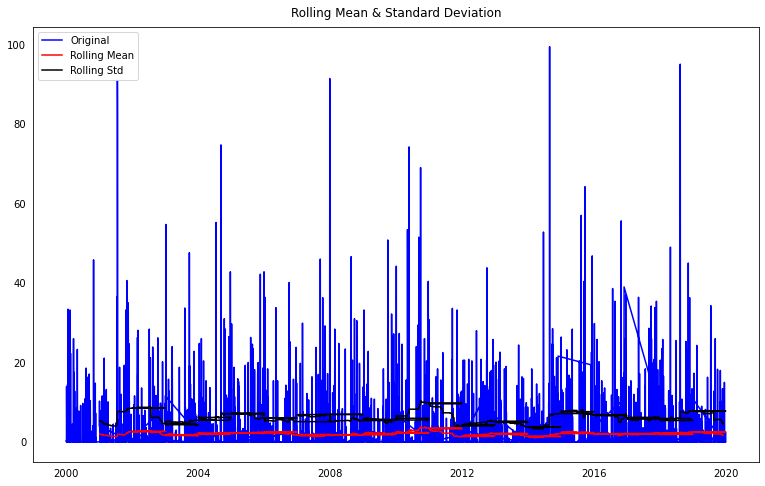

In [93]:
test = StationarityTest()
test.rolling_statistics_test(df_pr, window= 365)

### Yukarıda da görüldüğü üzere _yuvarlanmış standart sapma_ ve _yuvarlanmış ortalama_ değerleri zaman ile artan değerler değildir. Bu bilgi göz önünde bulundurulduğunda verimiz __stationary__ bir veridir diyebiliriz. Bu durumda verimizin üzerinde değişikler yapmamıza gerek olmayacaktır. Fakat bunu bahsettiğimiz diğer yöntem olan Augmented Dickey-Fuller Test ilede kontrol etmemiz daha iyi olacaktır.

In [83]:
test.dickey_fuller_test(df_pr)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -27.647921
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    7132.000000
Critical Value (1%)              -3.431267
Critical Value (5%)              -2.861945
Critical Value (10%)             -2.566986
dtype: float64


### Diğer testimiz olan Dickey-Fuller Testinide yaptığımızda tekrar görüyoruz ki verimiz __stationary__ bir veridir. Demekki verimizi bu yönde değiştirmemize gerek kalmayacak. Eğer verimiz istediğimiz gibi __stationary__ olmasaydı. Verimiz üzerinde _log difference_ gibi yöntemler yaparak verimizi __stationary__ formata sokmaya çalışacaktık. 

## Detaylı Görselleştirme
Veri ile ilgili daha detaylı bilgi arayışımızı bırakmak yerine, eğiteceğimiz ARIMA modelini seçmemize yardımcı olucak grafikler ile verimizi görselleştirelim. İlk olarak kullandığımız `statsmodels` kütüphanesinin grafik oluşturma metotlarından `plot_acf()` ve `plot_pacf()`'yi kullanarak verimizin auto-correlation ve partial auto-correlation grafiklerini göreceğiz.

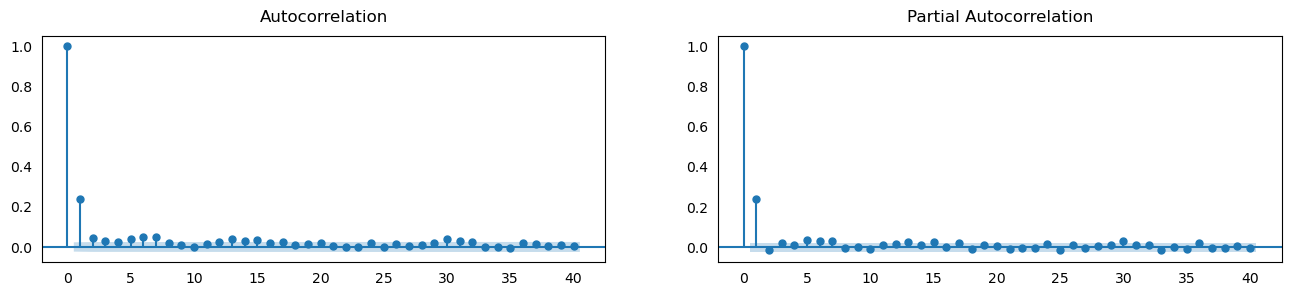

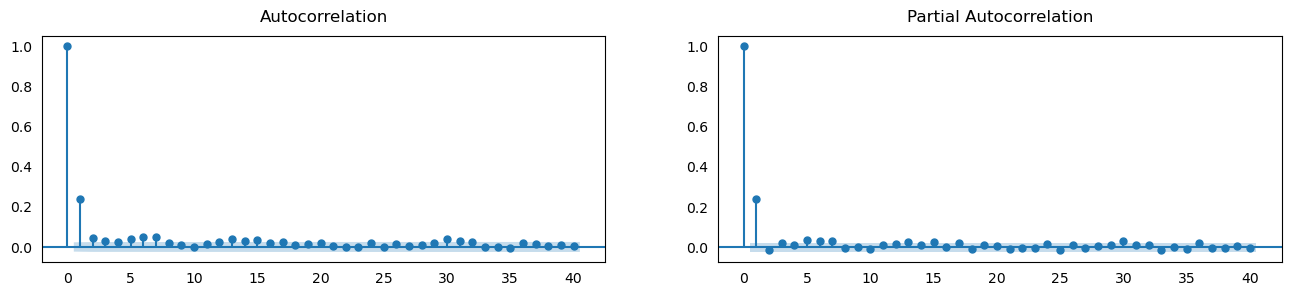

In [98]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_pr.precipitation, lags=40, ax=axes[0])
plot_pacf(df_pr.precipitation, lags=40, ax=axes[1])

# import statsmodels.api as sm

# fig = plt.figure(figsize=(12,8))
# ax1 = fig.add_subplot(211)
# fig = plot_acf(df_pr.precipitation, lags=40, ax=ax1) # 
# ax2 = fig.add_subplot(212)
# fig = plot_pacf(df_pr.precipitation, lags=40, ax=ax2)#

### Yukarıdaki beklentilerimizi kısaca açıklamamız gerekirse;
Bir k gecikme ile bir otoregresyon (AR) işlemi tarafından oluşturulan bir zaman serisini düşünün. Öncelikle ACF'nin, bir gözlem ile başka bir gözlem arasındaki otokorelasyonu, doğrudan ve dolaylı bağımlılık bilgilerini içeren önceki bir zaman adımında tarif ettiğini biliyoruz. Bu, AR (k) zaman serileri için ACF'nin bir k gecikmesine karşı güçlü olmasını bekleyeceğimiz anlamına gelir ve bu ilişkinin eylemsizliği, etkinin zayıflamasıyla bir noktada azalan sonraki gecikme değerlerine devam eder. PACF'nin sadece bir gözlem ile gecikmesi arasındaki doğrudan ilişkiyi tanımladığını biliyoruz. Bu, k'nın üzerindeki gecikme değerleri için bir korelasyon olmayacağını düşündürmektedir.

Bu, bir AR (k) süreci için ACF ve PACF grafiklerinin beklentisidir.

Hareketli ortalama (MA) işlemi ile k gecikmesi ile oluşturulan bir zaman serisini düşünün. Hareketli ortalama sürecinin, önceki tahminlerden kaynaklanan artık hataların zaman serilerinin bir otoregresyon modeli olduğunu unutmayın. Hareketli ortalama modeli düşünmenin bir başka yolu da, son tahminlerde yapılan hatalara dayanarak gelecekteki tahminleri düzeltmesidir. MA (k) prosesi için ACF'nin k gecikmesine kadar son değerlerle güçlü bir korelasyon göstermesini, daha sonra düşük veya hiç korelasyonda keskin bir düşüş beklemekteyiz. Tanım olarak, süreç bu şekilde üretildi. PACF için, planın gecikme ile güçlü bir ilişki göstermesini ve gecikmeden sonra korelasyonun bir sonunu göstermesini bekleriz.

Yine, bu tam olarak bir MA (k) süreci için ACF ve PACF grafiklerinin beklentisidir.

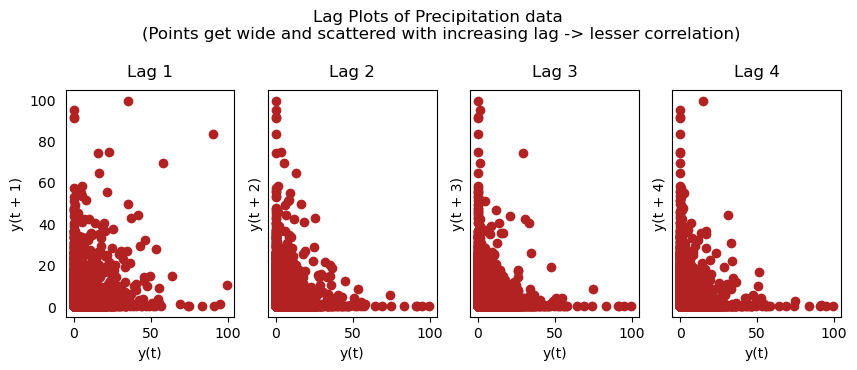

In [64]:

plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df_pr.precipitation, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Precipitation data \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    

plt.show()

<AxesSubplot:title={'center':'Backward Fill (MSE: 0.0)'}, xlabel='timeseries'>

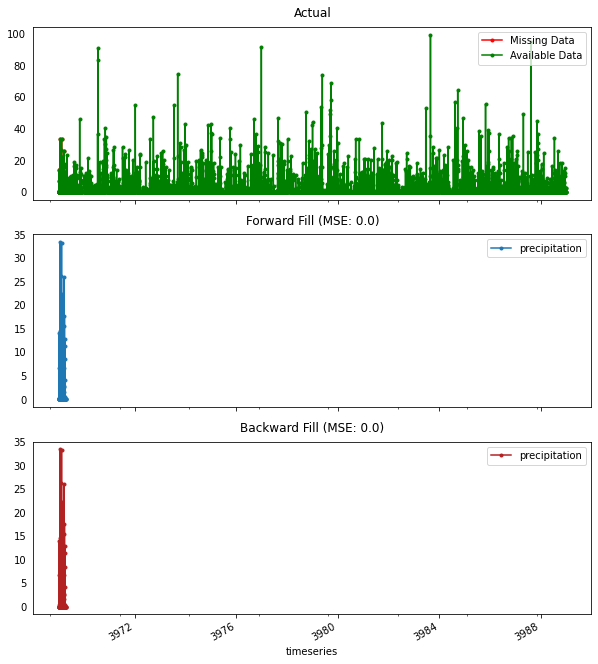

In [65]:
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
# df_orig = series.head(100)
# df = series
df_pr_orig = df_pr.head(100)

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10, 12))
plt.rcParams.update({'xtick.bottom' : False})

## 1. Actual -------------------------------
df_pr_orig.plot(title='Actual', ax=axes[0], label='Actual', color='red', style=".-")
df_pr.plot(title='Actual', ax=axes[0], label='Actual', color='green', style=".-")
axes[0].legend(["Missing Data", "Available Data"])

# 2. Forward Fill --------------------------
df_ffill = df_pr_orig.ffill()
error = np.round(mean_squared_error(df_pr_orig.values, df_ffill.values), 2)
df_ffill.plot(title='Forward Fill (MSE: ' + str(error) +")", ax=axes[1], label='Forward Fill', style=".-")

## 3. Backward Fill -------------------------
df_bfill = df_pr_orig.bfill()
error = np.round(mean_squared_error(df_pr_orig.values, df_bfill.values), 2)
df_bfill.plot(title="Backward Fill (MSE: " + str(error) +")", ax=axes[2], label='Back Fill', color='firebrick', style=".-")

# ARIMA Model Seçimi
Sırada model seçimi aşaması var. Bu aşamada ARIMA modelimizin `(p,d,q)` parametrelerine karar vereceğim ve karar verdikten sonra modeli eğiteceğim. Bu aşamada modelin kararını verebilmek için [ARIMA Docs](https://people.duke.edu/~rnau/411arim.htm) 'tan faydalandım. Buradaki modeller arasında karar verirken, verimin ilk aşamada stationary olması ve autocorrelated olmasını göz önünde bulundurdum. <br><br>
Seçtiğim ARIMA modelinin `(p,d,q)` parametreleri `(1,0,0)`'dır. Linkte belirttiğim ARIMA dökümanında da yazdığı üzere;
* Eğer seriler stationary ise,
* Eğer seriler auto-correlated ise,

'belki de kendi önceki değerinin bir katı artı bir sabit olarak tahmin edilebilir.' diye belirtilmektedir. Tahmin formülüde aşağıda belirtildiği gibidir.

>## `Ŷt  =  μ  +  ϕ1Yt-1`

… Ki bu da bir dönem gecikmeli olarak kendini geriledi. Bu bir “ARIMA (1,0,0) + sabit” modelidir. Y'nin ortalaması sıfır ise, sabit terim dahil edilmez.

Eğim katsayısı ϕ1 pozitif ve büyüklük olarak 1'den küçükse (Y sabitse büyüklük 1'den küçük olmalıdır), model, bir sonraki dönemin değerinin ϕ1 kat daha uzakta olacağı tahmin edilen ortalama geri dönüş davranışını tanımlar bu dönemin değeri olarak ortalamadan. Eğer ϕ1 negatifse, işaretlerin değişmesi ile ortalama geri dönüş davranışını tahmin eder, yani, bu dönemin ortalamasının üzerinde olması durumunda Y'nin bir sonraki dönemin altında olacağını da tahmin eder.

İkinci dereceden otoregresif bir modelde (ARIMA (2,0,0)), sağda da bir Yt-2 terimi olacaktı. Katsayıların işaret ve büyüklüklerine bağlı olarak, bir ARIMA (2,0,0) modeli, ortalama geri dönüşü, sinüzoidal olarak salınan bir tarzda gerçekleşen, örneğin bir kütlenin rastgele şoklara maruz kalan bir yay üzerindeki hareketi gibi tanımlayabilir. .

In [118]:
arima_mod1 = ARIMA(df_pr.precipitation, (6, 1, 0)).fit(disp=False)
print(arima_mod1.summary())

C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32

NormaltestResult(statistic=6617.505796328907, pvalue=0.0)


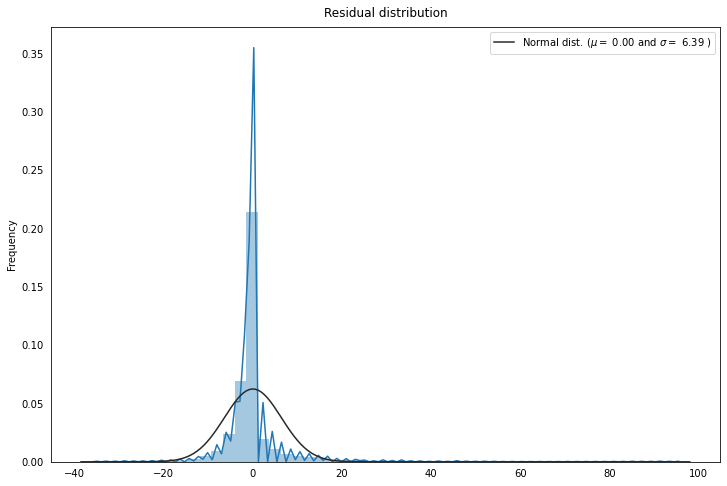

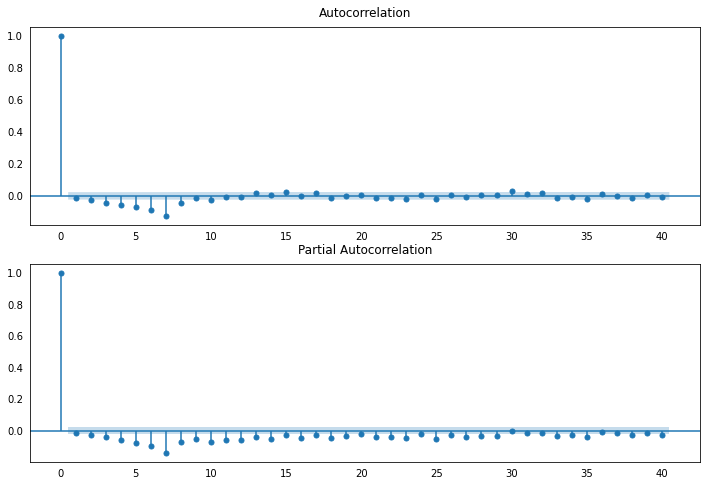

In [119]:
from scipy import stats
from scipy.stats import normaltest
import seaborn as sns

resid = arima_mod1.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(arima_mod1.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(arima_mod1.resid, lags=40, ax=ax2)

C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\k84167261\AppData\Local\Programs\Python\Python38-32

<AxesSubplot:xlabel='timeseries'>

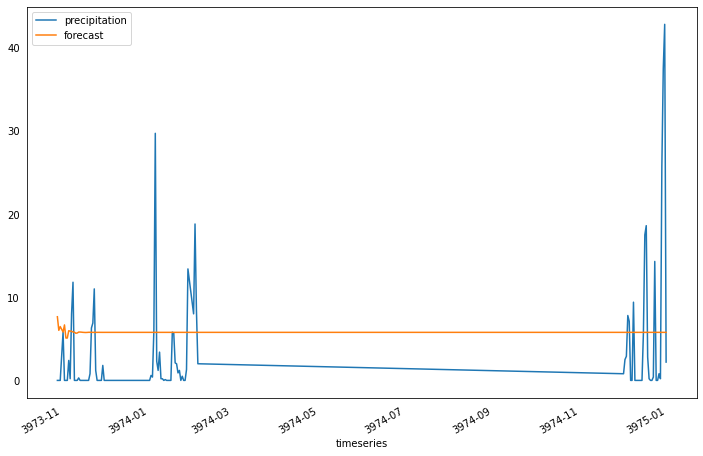

In [116]:
sarima_mod6 = sm.tsa.statespace.SARIMAX(df_pr.precipitation, trend='n', order=(6,1,0)).fit()
print(sarima_mod6.summary())
start_index = 1730
end_index = 1826
train_df = df_pr
train_df['forecast'] = sarima_mod6.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['precipitation', 'forecast']].plot(figsize=(12, 8))


In [9]:
data.samplez(10)

precipitation  vaporization
timeseries                             
2004-07-10            0.0           4.0
2015-05-08            6.4           2.1
2004-12-09            1.8           0.0
2004-02-27            0.0           0.0
2004-09-29            0.0           1.1
2004-02-12            1.4           0.0
2001-10-05            0.2           0.0
2001-09-07            0.0           2.5
2011-04-13            0.4           1.0
2012-08-05            0.0           3.2